#输入4维张量数据进行cycle life预测


1.   完整数据
2.   稀疏数据
3.   稀疏填充后的数据



In [21]:
# from google.colab import drive
# drive.mount("/content/drive")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import os
print("当前路径:", os.getcwd())

当前路径: C:\Users\Administrator\pyworkspace


#get data
*   首先将特征数据从txt文件中处理成一个四维张量，然后按照battery id排成一个矩阵输入RF中
*   标签数据额外读取一个文件


In [22]:
def loadData(dataset_path, split=" "):
  data_item_list = []
  # 一条数据项(data_item)内所包含的信息按顺序展示为:
  # batteryId::sampleId::tcycleId::typeId::rating
  with open(dataset_path) as fin:
    # next(fin)  # cast into oblivion
    for data_item in fin:
      temp_tuple = data_item.strip().split(split)[:5]
      temp_tuple[0] = int(temp_tuple[0])  # 电池ID
      temp_tuple[1] = int(temp_tuple[1])  # 采样ID
      temp_tuple[2] = int(temp_tuple[2])  # 循环ID
      temp_tuple[3] = int(temp_tuple[3])  # 属性ID
      temp_tuple[4] = float(temp_tuple[4])  # 值
      data_item_list.append(tuple(temp_tuple))
  return data_item_list
path2='D:/dataset/toyota/不同填充方法填充后的全张量数据/'
feature_data = loadData(path2+'toyota_4Dtensor_124_200_100_7_data_s0.99_p80_fulledbySGDL3_r40_l0.0_l20.0_eta0.05_norway1.txt')


In [23]:
import numpy as np
print(np.array(feature_data).shape)

(17360000, 5)


In [24]:
from tqdm import tqdm
def getMaxMin(data):
  #获取元素最大最小值
  battery_list = [i[0] for i in data]
  sample_list = [i[1] for i in data]
  cycle_list = [i[2] for i in data]
  type_list = [i[3] for i in data]
  battery_num=max(battery_list)+1
  sample_num=max(sample_list)+1
  cycle_num= max(cycle_list)+1
  type_num= max(type_list)+1

  return battery_num, sample_num, cycle_num, type_num

battery_num, sample_num, cycle_num, type_num=getMaxMin(feature_data)

#创建一个四维数组存储全张量数据
battery_tensor = np.zeros((battery_num, sample_num, cycle_num, type_num))

#将已知元素填充到张量battery_tensor中
for each_interaction in tqdm(feature_data, total=len(feature_data)):
  battery_tensor[each_interaction[0]][each_interaction[1]][each_interaction[2]][each_interaction[3]] = each_interaction[4]

100%|█████████████████████████████████████████████████████████████████| 17360000/17360000 [00:08<00:00, 1960005.95it/s]


In [25]:
print(battery_num, sample_num, cycle_num, type_num)
# print(np.array(battery_tensor).shape)
# battery_list = [i[0] for i in data]
# print(len(battery_list))

124 200 100 7


In [26]:
'''
特征数据处理
'''
feature_list=[]  #定义LSTM输入数据
# 按照第四维进行切片并分成多个矩阵
# battery_tensor.shape=(43, 1000, 100, 4),按照循环次数（即battery_tensor的第3个维度）划分矩阵切片，
mats_in_timeslice = np.split(battery_tensor, battery_tensor.shape[0], axis=0) #mats_in_timeslice的列表长度为电池ID
for i in range(battery_tensor.shape[0]):
  input_vector=mats_in_timeslice[i].reshape(-1)
  feature_list.append(input_vector)

# 遍历一维数组并拼接成二维数组
model_feature_input = None
for vector in feature_list:
  if model_feature_input is None:
    model_feature_input = vector
  else:
    model_feature_input = np.vstack((model_feature_input, vector))

print(model_feature_input.shape)

MODEL_INPUT_SIZE=model_feature_input.shape[1]

(124, 140000)


In [27]:
'''
标签数据处理
'''
label_path='D:/dataset/toyota/toyota_4Dtensor_label_124_cyclelife.txt'
# label_path='D:/dataset/toyota/toyota_4Dtensor_label_124_soh_c300.txt'
label_list=[]
with open(label_path) as file:
  # next(file)  # 跳过标题
  for label_item in file.readlines():
    temp_item = float(label_item.strip())
    label_list.append(temp_item)
model_label_input=np.array(label_list)  #列表转为数组

In [28]:
print(len(model_label_input))

124


In [29]:
'''
输入模型的训练测试集划分
'''
def train_test_nn(feature_data, label_data):
  train_begin=0
  train_end=100
  test_begin=100

  train_x=feature_data[train_begin:train_end]
  test_x=feature_data[test_begin:]

  train_y=label_data[train_begin:train_end]
  # train_y=train_y/1.2
  test_y=label_data[test_begin:]
  # test_y=test_y/1.2

  return train_x,train_y,test_x,test_y

train_x,train_y,test_x,test_y=train_test_nn(model_feature_input,model_label_input)

In [30]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(100, 140000)
(100,)
(24, 140000)
(24,)


# Feature Scaling

In [31]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(train_x)
X_test = sc.transform(test_x)


#Training the Algorithm

In [32]:
#循环调参

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
n_estimators_list=[13]
random_state_list=[11]
max_features_list=[32]
max_depth_list=[14]

for a in n_estimators_list:
  for b in random_state_list:
    for c in max_features_list:
      for d in max_depth_list:
        regressor = RandomForestRegressor(n_estimators=a, random_state=b, max_features=c, max_depth=d ) #criterion="mse",oob_score=True,min_samples_split=2
        regressor.fit(X_train, train_y)
        y_pred = regressor.predict(X_test)
#         print(round(metrics.mean_absolute_error(test_y, y_pred),9),round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),9))#'test_MAE', #'test_RMSE',
        RMSE=round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),9)
        MAE=round(metrics.mean_absolute_error(test_y, y_pred),9)
#         print(a,b,c,d,RMSE,MAE)#'test_MAE', #'test_RMSE',
        print(RMSE,MAE)#'test_MAE', #'test_RMSE',

292.139190215 225.849358974


#Evaluating the Algorithm



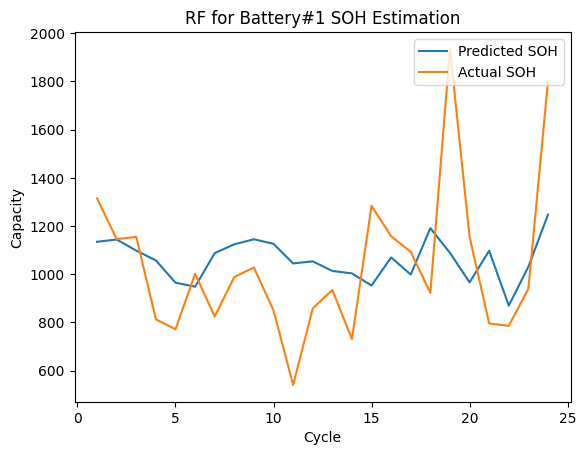

In [33]:
from sklearn import metrics

# print('test_MAE', round(metrics.mean_absolute_error(test_y, y_pred),3))
# print('test_RMSE', round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),3))

# print(round(metrics.mean_absolute_error(test_y, y_pred),3))#'test_MAE',
# print(round(np.sqrt(metrics.mean_squared_error(test_y, y_pred)),3))#'test_RMSE',


#draw
x_aix_1 = np.arange(1, len(test_y) + 1)
plt.plot(x_aix_1, y_pred, label='Predicted SOH')  #测试集的预测值
plt.plot(x_aix_1, test_y, label='Actual SOH' ) #测试集的真实值
plt.title("RF for Battery#1 SOH Estimation")
# plt.xticks([500,1000,1500,2000,2500], fontsize = 20)
plt.xlabel('Cycle')  #, fontsize=20
plt.ylabel('Capacity')  #, fontsize=20
# plt.legend(fontsize=20)
plt.legend(loc='upper right')
plt.show()

# print(y_pred1)

#Print predict value

In [34]:
for i in range(len(y_pred)):
    print(y_pred[i])#i, test_y[i],

1134.923076923077
1144.2307692307693
1098.1538461538462
1057.4615384615386
965.3076923076923
948.3846153846154
1087.6153846153845
1124.4615384615386
1145.2307692307693
1126.4615384615386
1045.0
1053.7692307692307
1013.8461538461538
1003.6153846153846
953.6153846153846
1069.923076923077
998.7692307692307
1191.4615384615386
1089.076923076923
966.4615384615385
1097.6153846153845
870.2307692307693
1031.2307692307693
1247.3846153846155
